In [3]:
import pandas as pd
from pathlib import Path


PROJECTDIR = Path('.').resolve().parents[2]

matpath = '../data/Kulcenty2019_GSE134061_series_matrix.txt'
sampmappath = '../data/Kulcenty2019_samplemap.txt'
lcapath = '../data/Table_S3_miRNA_loss.tsv'


def read_sampmap(path):
    mapdict = {'ID_REF': 'geneid'}
    with open(path, 'r') as fh:
        for line in fh:
            gsmid, newid = line.strip().split()[:2]
            mapdict[gsmid] = newid
    return mapdict


def read_lca(path):
    old = []
    m = []
    with open(path) as fh:
        header = next(fh)
        for line in fh:
            gain, mirfam = line.split()[:2]
            if gain in ['Vertebrata', 'Gnathostomata']:
                old.append(mirfam)
            elif gain == 'Eutheria':
                m.append(mirfam)
            
    return old, m


gsm2id = read_sampmap(sampmappath)
matdf = pd.read_csv(matpath, sep='\t', comment='!')
matdf = matdf.rename(columns=gsm2id)
matdf['geneid'] = matdf['geneid'].apply(lambda x: x.split('_')[0])
display(matdf)
    

,geneid,ipsc1_1,ipsc2_1,ipsc1_2,ipsc2_2,nsc1_1,nsc1_2,nsc2_1,nsc2_2
0,14q0,0.834540,0.889142,0.886466,0.828477,0.898016,1.063181,0.910019,1.120857
1,14qI-1,1.209647,1.813813,1.748750,1.879969,1.536834,1.624633,1.524025,1.715140
2,14qI-1,1.232854,1.727948,1.673267,1.894515,1.536834,1.624633,1.578746,1.715140
3,14qI-2,0.550139,0.728178,0.791553,0.934820,0.716010,0.758594,0.812993,0.707159
4,14qI-3,0.658313,0.756557,0.674726,0.811295,0.681971,0.597687,0.606142,0.675370
...,...,...,...,...,...,...,...,...,...
36348,U97,1.911146,2.234803,2.279276,2.187733,2.252512,2.279276,2.810257,2.457072
36349,U98b,1.015929,1.132998,1.301542,1.103143,0.983124,1.079279,1.271012,1.110275
36350,U98b,0.744720,0.882433,0.916885,0.761983,0.556319,0.715386,0.846593,0.741092
36351,U99,4.409251,3.696086,4.739974,3.834232,3.549115,3.796841,3.749801,3.172256


## Find mat-mirbase id for each family representative

In [5]:

lossfampath = f'{PROJECTDIR}/external_data/all_rodentlost_mirfams.list'
gffpath = '../data/hsa.gff'


def read_lossfams(path):
    with open(path) as fh:
        f = [line for line in fh.read().split('\n') if line]
    return f

def parse_gff(path, lf):
    f2m = {}
    mir2m = {}
    with open(path, 'r') as fh:
        for line in fh:
            if line.startswith('#'):
                continue
            lindat = line.strip().split()
            #print(lindat)
            if lindat[2] != 'miRNA':
                continue
            infostr = lindat[-1]
            if not "Alias" in infostr:
                continue
            raw_mirgene, raw_matid = infostr.split(';')
            matid = raw_matid.split('=')[1]
            if raw_mirgene.endswith('*'):
                continue
            mirgene = raw_mirgene.split('_')[0].split('=')[1]
            mirfam = '-'.join(raw_mirgene.split('_')[0].split('-')[1:3])
            if mirfam not in lf:
                continue
            #print(mirfam, matid)
            if not mirfam in f2m:
                f2m[mirfam] = []
            f2m[mirfam].append(matid)
            mir2m[mirgene] = matid
            mir2m[matid] = mirgene
    return f2m, mir2m
            

lossfams = read_lossfams(lossfampath)
oldmirs, mammalmirs = read_lca(lcapath)
fam2mat, mir2mat = parse_gff(gffpath, lossfams + oldmirs + mammalmirs)
#display(mir2mat)

print(len(fam2mat.keys()))


153


## Find miRNA lost in rodents in the iPSC array dataset

In [6]:
pd.set_option('mode.chained_assignment', None)


def mir2fam(mir):
    fam = '-'.join(mir.split('-')[1:3])
    return fam

lostdf = matdf[matdf['geneid'].isin(list(mir2mat.values()))]
lostdf['mirid'] = lostdf['geneid'].apply(lambda x: mir2mat[x])
lostdf['mirfam'] = lostdf['mirid'].apply(lambda x: mir2fam(x))
lostdf = lostdf.sort_values('mirid')
#lostdf = lostdf.set_index('mirid')
#display(lostdf)

mam = lostdf[lostdf['mirfam'].isin(mammalmirs)]
display(mam)
display(mam[~mam['mirfam'].isin(lossfams)])

,geneid,ipsc1_1,ipsc2_1,ipsc1_2,ipsc2_2,nsc1_1,nsc1_2,nsc2_1,nsc2_2,mirid,mirfam
5810,MIMAT0000102,3.559691,4.967799,3.609313,1.727431,3.314512,3.067247,3.159461,2.140877,Hsa-Mir-105-P2,Mir-105
11338,MIMAT0005825,5.212579,5.575780,5.884998,4.601188,6.924153,6.766234,6.945394,7.098119,Hsa-Mir-1180,Mir-1180
11408,MIMAT0005899,1.238176,1.218058,0.878360,0.875031,4.228861,3.548124,1.349936,1.203568,Hsa-Mir-1247,Mir-1247
11410,MIMAT0005901,2.210065,3.353821,2.764145,2.135742,1.649970,3.505631,2.790382,3.270403,Hsa-Mir-1249,Mir-1249
6152,MIMAT0000446,1.180414,1.131181,1.661843,1.180236,1.857015,1.765608,2.511025,1.516596,Hsa-Mir-127,Mir-127
...,...,...,...,...,...,...,...,...,...,...,...
9490,MIMAT0003888,2.556951,3.867799,2.831667,2.594963,4.281395,3.781697,3.711453,2.968831,Hsa-Mir-766,Mir-766
9488,MIMAT0003886,4.375613,3.775255,2.995885,3.847021,5.497737,4.814134,4.911949,3.971778,Hsa-Mir-769,Mir-769
10443,MIMAT0004911,6.265597,5.951401,6.065077,6.031508,6.581254,6.455952,6.158863,5.666526,Hsa-Mir-874,Mir-874
10455,MIMAT0004925,0.666357,0.914452,0.640023,0.974913,0.944320,1.063595,0.605551,0.983041,Hsa-Mir-876,Mir-876


,geneid,ipsc1_1,ipsc2_1,ipsc1_2,ipsc2_2,nsc1_1,nsc1_2,nsc2_1,nsc2_2,mirid,mirfam
5810,MIMAT0000102,3.559691,4.967799,3.609313,1.727431,3.314512,3.067247,3.159461,2.140877,Hsa-Mir-105-P2,Mir-105
11338,MIMAT0005825,5.212579,5.575780,5.884998,4.601188,6.924153,6.766234,6.945394,7.098119,Hsa-Mir-1180,Mir-1180
11408,MIMAT0005899,1.238176,1.218058,0.878360,0.875031,4.228861,3.548124,1.349936,1.203568,Hsa-Mir-1247,Mir-1247
11410,MIMAT0005901,2.210065,3.353821,2.764145,2.135742,1.649970,3.505631,2.790382,3.270403,Hsa-Mir-1249,Mir-1249
6152,MIMAT0000446,1.180414,1.131181,1.661843,1.180236,1.857015,1.765608,2.511025,1.516596,Hsa-Mir-127,Mir-127
...,...,...,...,...,...,...,...,...,...,...,...
22568,MIMAT0018204,0.788857,0.681424,0.802210,0.710722,0.880142,0.822360,0.879484,0.882455,Hsa-Mir-676,Mir-676
10474,MIMAT0004945,8.082264,8.901690,8.358291,8.133137,9.113462,9.067637,8.424790,8.471281,Hsa-Mir-744,Mir-744
10486,MIMAT0004957,3.191460,2.113980,3.446812,1.700021,3.263785,3.039527,3.282450,2.426789,Hsa-Mir-760,Mir-760
10443,MIMAT0004911,6.265597,5.951401,6.065077,6.031508,6.581254,6.455952,6.158863,5.666526,Hsa-Mir-874,Mir-874


In [19]:
loopdf = lostdf.drop(columns=['nsc1_1', 'nsc1_2', 'nsc2_1', 'nsc2_2'])

cd = {'mirfam': [], 'expression': []}
for line in loopdf.to_string(header=False, index=False).split('\n'):
    matid, dat1, dat2, dat3, dat4, mirid, mirfam = line.strip().split()
    #mirfam = '-'.join(mirid.split('-')[1:3])
    if mirfam in lossfams:
        mirfam = mirfam
    elif mirfam in mammalmirs:
        mirfam = 'Eutheria'
    elif mirfam in oldmirs:
        mirfam = 'Vertebrata'
    for point in [dat1, dat2, dat3, dat4]:
        cd['mirfam'].append(mirfam)
        cd['expression'].append(float(point))
    
    
visdf = pd.DataFrame.from_dict(cd)
display(visdf)

,mirfam,expression
0,Vertebrata,2.228114
1,Vertebrata,1.490479
2,Vertebrata,1.767021
3,Vertebrata,2.213126
4,Vertebrata,1.364561
...,...,...
1167,Vertebrata,9.750944
1168,Vertebrata,5.213213
1169,Vertebrata,7.236838
1170,Vertebrata,5.581275


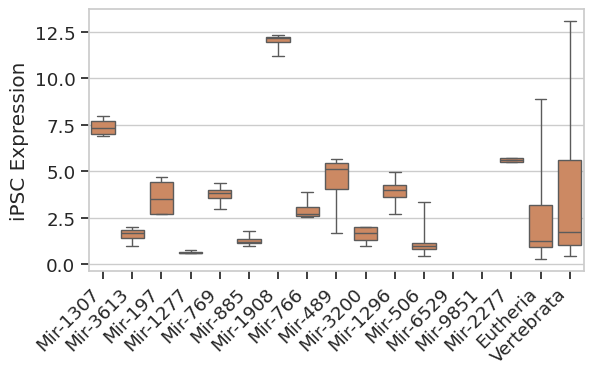

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


oldmed = visdf['expression'][visdf['mirfam'] == 'Vertebrata'].median()
cmap = sns.color_palette()
norder = [
    'Mir-1307',
    'Mir-3613',
    'Mir-197',
    'Mir-1277',
    'Mir-769',
    'Mir-885',
    'Mir-1908',
    'Mir-766',
    'Mir-489',
    'Mir-3200',
    'Mir-1296',
    'Mir-506',
    'Mir-6529',
    'Mir-9851',
    'Mir-2277',
    'Eutheria',
    'Vertebrata'
]
#sns.set_theme('paper')
sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')
sns.boxplot(data=visdf, x='mirfam', y='expression', order=norder, color=cmap[1], whis=20)
#plt.axhline(y=oldmed, color='dimgrey', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('iPSC Expression')
plt.tight_layout()
plt.savefig(f'{PROJECTDIR}/publication/revision/ipscKulcenty2019_boxplot_rodlosfams.pdf')
plt.show()